In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
%matplotlib inline

# Data Exploration:
# Salt Lake City (SLC) Air Quality Analysis

### Data Overview

This dataset explores the air quality in Salt Lake City, Utah between the years 2000 and 2017.  

Air quality is reported as an air quality index (AQI) and takes into consideration 5 main pollutants regulated by the Clean Air Act: ozone, carbon monoxide, sulfur dioxide, nitrogen dioxide, and coarse and fine particulate matter (PM10 and PM2.5, respectively).  

The US EPA establishes acceptable concentration ranges for each pollutant type and assigns an overall AQI value and health classification based on the following scale:  

<img src='AQI.JPG' align="center">
*Image source: https://airnow.gov/index.cfm?action=aqibasics.aqi*

The dataset comes from the US EPA (https://www.epa.gov/outdoor-air-quality-data) and is a csv file containing 5 columns: date, main source of pollution contributing to the AQI for a given day, monitoring location site name, monitoring location site ID, and daily AQI value. Only one monitoring location is listed for each day and it's unclear how the reported location is determined.

Let's take an initial look at the data.

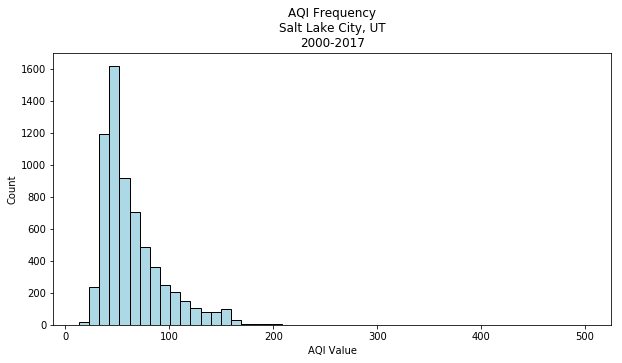

               aqi
count  6544.000000
mean     63.971119
std      29.605810
min      13.000000
25%      44.000000
50%      54.000000
75%      77.000000
max     501.000000


,classification,count,percent
0,Good,2798,42.756724
1,Moderate,2982,45.568460
2,Sensitive Groups,625,9.550733
3,Unhealthy,135,2.062958
4,Very Unhealthy,3,0.045844
5,Hazardous,1,0.015281


In [3]:
#To replicate data set, go to https://www.epa.gov/outdoor-air-quality-data, select visualize data --> 
#tile plot - multiyear --> run for all pollutant types, 2000 through 2017 in Salt Lake City.  
#Download data from csv link generated.

#Import data, rename column headers
airquality = pd.read_csv('C:/Users/Doug/OneDrive/Python/PrepCapstone/SLC_AQI.csv')
airquality.columns = ['date', 'primary pollutant', 'location', 'location ID', 'aqi']

#Plot histogram of all AQI values
plt.figure(figsize=(10, 5)) 
plt.hist(airquality.aqi, edgecolor='black', bins=50, color='lightblue')
plt.title('AQI Frequency\nSalt Lake City, UT\n2000-2017')
plt.ylabel('Count')
plt.xlabel('AQI Value')
plt.show()

#Run summary statistics
print(airquality.describe())

#Assign health classification based on EPA scale
good = airquality[airquality.aqi <= 50]
moderate = airquality[airquality.aqi.between(51, 100, inclusive=True)]
sensitive = airquality[airquality.aqi.between(101, 150, inclusive=True)]
unhealthy = airquality[airquality.aqi.between(151, 200, inclusive=True)]
very_un = airquality[airquality.aqi.between(201, 300, inclusive=True)]
haz = airquality[airquality.aqi >= 300]

#Summarize health classification into new df, count occurances of each, determine percent 
health_summary = pd.DataFrame()

health_summary['classification'] = ['Good', 'Moderate', 'Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

health_summary["count"] = [ 
    good.aqi.count(), 
    moderate.aqi.count(), 
    sensitive.aqi.count(),
    unhealthy.aqi.count(), 
    very_un.aqi.count(),
    haz.aqi.count()
]

health_summary["percent"] = [
    good.aqi.count()/airquality.aqi.count()*100,
    moderate.aqi.count()/airquality.aqi.count()*100,
    sensitive.aqi.count()/airquality.aqi.count()*100,
    unhealthy.aqi.count()/airquality.aqi.count()*100,
    very_un.aqi.count()/airquality.aqi.count()*100,
    haz.aqi.count()/airquality.aqi.count()*100
]

health_summary

Overall, this data set contains 6544 values.  The majority of AQI values are less than 100, with an average of 64.  This means air quality is typically rated as good (42% of the time) or moderate (45% of the time).  However, there are quite a few AQIs greater than 100, indicating some level of public health concern.  There's even an AQI of 501 which exceeds the  EPA scale shown above.  It's possible this value could be erroneous, perhaps from a bad sensor reading, and need to be thrown out.  Let's take a closer look at what might be going on.

In [4]:
#Query outlier value to determine date. Perform Google search on "date + SLC air quality"
airquality.loc[airquality['aqi'] == 501]

,date,primary pollutant,location,location ID,aqi
3741,3/30/2010,PM10,Magna,49-035-1001,501


The high value corresponds to March 30, 2010.  A Google search of this date reveals unusually high winds lead to a severe dust storm in the region, leading to short-term hazardous air conditions. Interesting.  So it represents a real value.

What about sources of pollution?  Let's look at the breakdown of that data:

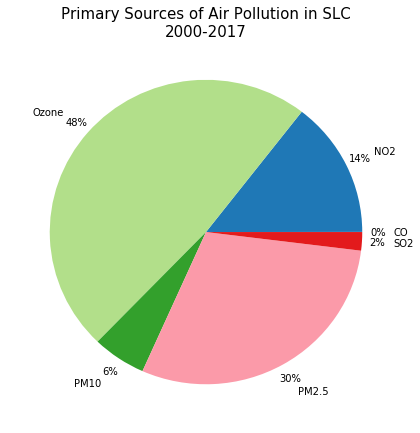

In [5]:
#Create new df to count pollutant occurrences
sources = pd.DataFrame()

#Group by pollutant type and count occurrences
sources['count'] = airquality['primary pollutant'].groupby(airquality['primary pollutant']).count()

#Create pie chart elements
labels = ['CO', 'NO2', 'Ozone', 'PM10', 'PM2.5', 'SO2']
colors = ['#a6cee3', '#1f78b6', '#b2df8a', '#33a02c', '#fb9aa9', '#e31a1c']

#Create pie chart
plt.figure(figsize=(7,7))
plt.pie(sources['count'], startangle=0, labels=labels, colors=colors, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.title('Primary Sources of Air Pollution in SLC\n2000-2017', size=15)
plt.show()

Looks like ozone and small particle particulates are the primary air pollutants in SLC.  Carbon monoxide and sulfur dioxide are the least common. 

### Analytical Question #1: Where is the data collected?  How do the different monitoring locations compare to each other?  

We're provided a column of data with different sampling locations.  Let's start by looking at how many locations data is collected from and how many AQI values come from each location.

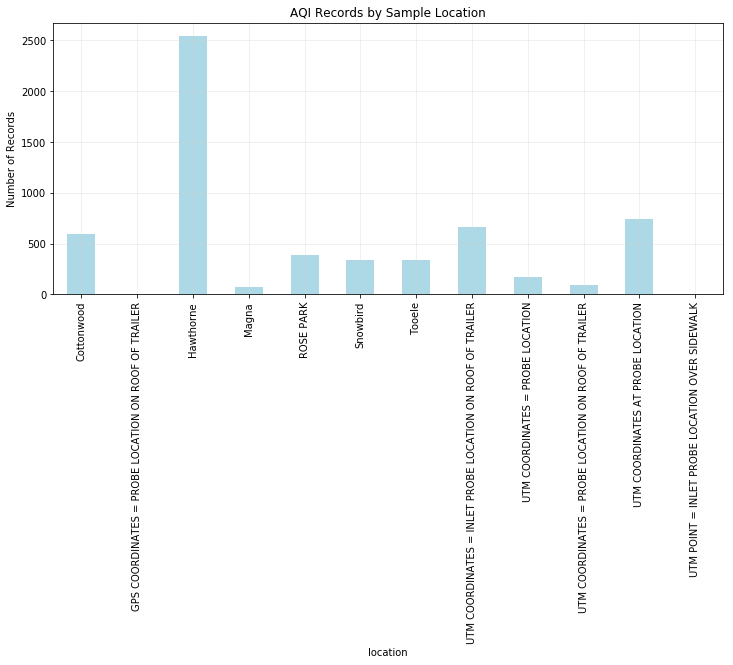

In [6]:
#setup plot layout
plt.figure(figsize=(12,5))

#generate data based on location
airquality['location'].groupby(airquality['location']).count().plot(kind='bar', color='lightblue')

#customize plot
plt.ylabel('Number of Records')
plt.grid(color='lightgrey', alpha=0.4)
plt.title('AQI Records by Sample Location')
plt.show()

There are 12 locations from which air quality data was collected.  We see that the Hawthorne location was by far the most frequently recorded sampling location with over 2500 records.  

We also see that 6 of the locations appear to originate from a mobile sampling trailer (GPS or UTM coordinates on trailer).  Since the exact locations of the trailer are unknown and likely change from measurement to measurement, let's look at the data collected from the fixed sampling locations only to see if there are any geographical biases. 

c:\users\doug\appdata\local\programs\python\python36-32\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


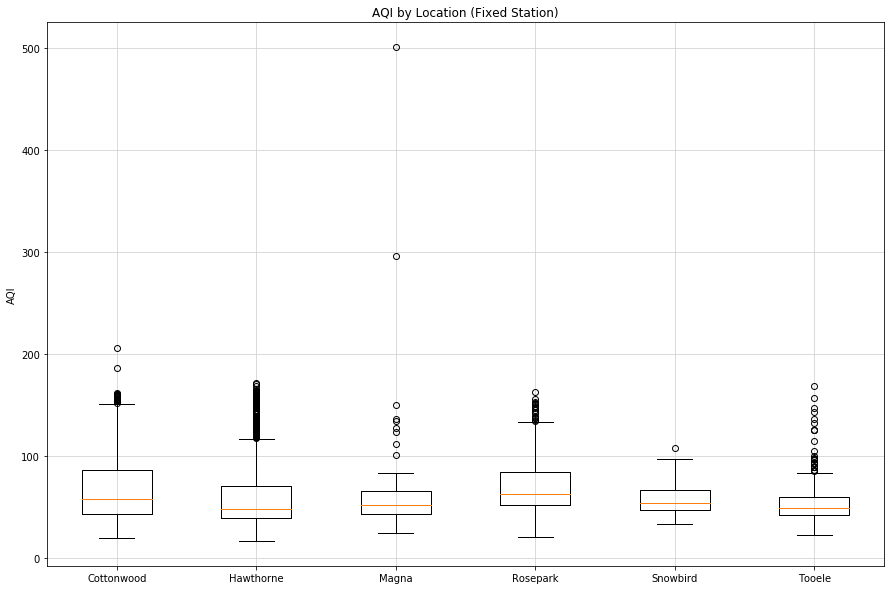

In [7]:
#Select data based on fixed sampling locations; create new df for each location.
cottonwood = airquality[airquality['location'] == 'Cottonwood']
hawthorne = airquality[airquality['location'] == 'Hawthorne']
magna = airquality[airquality['location'] == 'Magna']
rosepark = airquality[airquality['location'] == 'ROSE PARK']
snowbird = airquality[airquality['location'] == 'Snowbird']
tooele = airquality[airquality['location'] == 'Tooele']

#Create data to plot
data = [cottonwood.aqi, hawthorne.aqi, magna.aqi, rosepark.aqi, snowbird.aqi, tooele.aqi]

#Generate list of locations to use in x label
location = ['Cottonwood', 'Hawthorne', 'Magna', 'Rosepark', 'Snowbird', 'Tooele']

#Plot by location data and customize layout
plt.figure(figsize=(15,10))
plt.boxplot(data)
plt.grid(color='lightgrey')
plt.title('AQI by Location (Fixed Station)')
plt.xticks([1, 2, 3, 4, 5, 6], location)
plt.ylabel('AQI')
plt.show()


The plot above shows fairly consistent AQI measurements among the different fixed sampling locations. With the exception of Snowbird, all sampling locations had many outliers.  It's interesting to see that the Magna sample location recorded 2 of the 3 highest AQIs.

### Analytical Question #2: Are there seasonal variations in the data?

Let's take a closer look at how air quality varies throughout the year.  Is the AQI higher or lower in particular months?

c:\users\doug\appdata\local\programs\python\python36-32\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


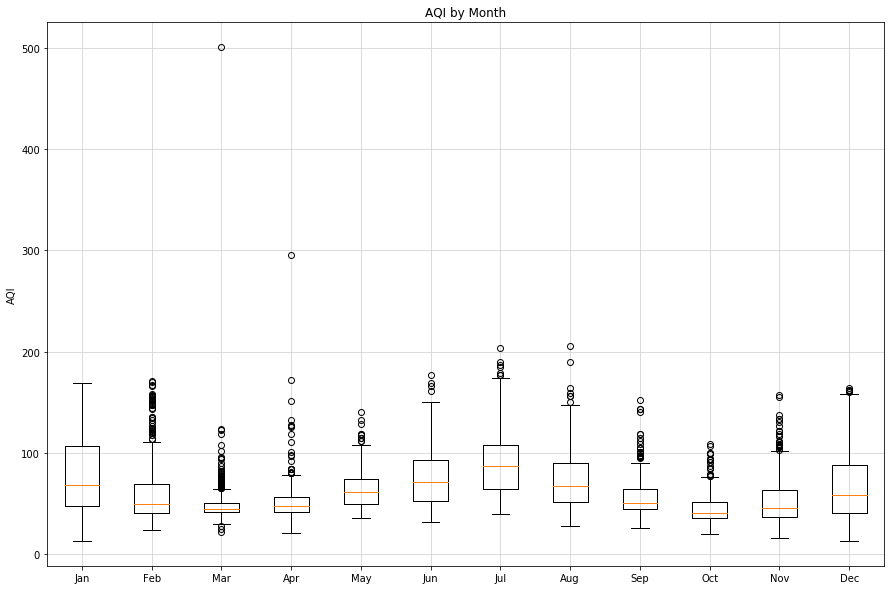

In [13]:
#convert date from object to datetime64[ns] format so we can select by month
airquality.date = pd.to_datetime(airquality.date)

#classify into months; create new df for each month
jan = airquality[airquality.date.dt.month == 1]
feb = airquality[airquality.date.dt.month == 2]
mar = airquality[airquality.date.dt.month == 3]
apr = airquality[airquality.date.dt.month == 4]
may = airquality[airquality.date.dt.month == 5]
jun = airquality[airquality.date.dt.month == 6]
jul = airquality[airquality.date.dt.month == 7]
aug = airquality[airquality.date.dt.month == 8]
sep = airquality[airquality.date.dt.month == 9]
oct = airquality[airquality.date.dt.month == 10]
nov = airquality[airquality.date.dt.month == 11]
dec = airquality[airquality.date.dt.month == 12]

#Generate data for plot
data = [jan.aqi, feb.aqi, mar.aqi, apr.aqi, may.aqi, jun.aqi, jul.aqi, aug.aqi, sep.aqi, oct.aqi, nov.aqi, dec.aqi]

#Generate list of months to use in x label
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
 
#Plot by month data and customize layout
plt.figure(figsize=(15,10))
plt.boxplot(data)
plt.grid(color='lightgrey')
plt.title('AQI by Month')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], month)
plt.ylabel('AQI')
plt.show()


Based on the plot above, we see seasonal trends emerge.  AQI tends to be the highest in Dec/Jan with winter inversions, and then increase again in summer months (June - Aug).  AQI values are the lowest in spring and fall months, likely due to shifting weather patterns that prevent air from stagnating in the valley floor.  

What about sources of pollution?  Is there any seasonal variation to that?  Let's compare the primary pollution sources from January and July, the two months with the highest average AQIs.

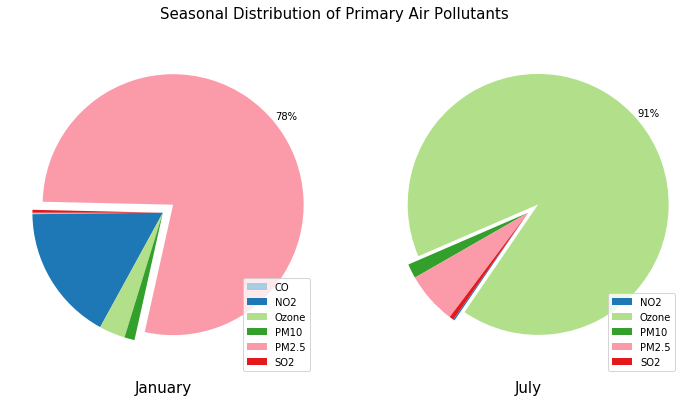

In [22]:
#Group by and count pollutant type for January and July data
jan_pollution = jan['primary pollutant'].groupby(jan['primary pollutant']).count() 
jul_pollution = jul['primary pollutant'].groupby(jul['primary pollutant']).count()

#January labels
jan_labels = ['CO', 'NO2', 'Ozone', 'PM10', 'PM2.5', 'SO2']
jan_colors = ['#a6cee3', '#1f78b6', '#b2df8a', '#33a02c', '#fb9aa9', '#e31a1c']

#July labels - not all pollutant types present, missing CO.  Force color scheme to be 
#consistent with January.
jul_labels = ['NO2', 'Ozone', 'PM10', 'PM2.5', 'SO2']
jul_colors = ['#1f78b6', '#b2df8a', '#33a02c', '#fb9aa9', '#e31a1c']

#create custom label to display percent of largest slice.  All other values return blank.
def my_autopct(pct):
    return ('%.0f%%' % pct) if pct > 50 else ''

#specify plot layout and subplot title
plt.figure(figsize=(12,6))
plt.suptitle('Seasonal Distribution of Primary Air Pollutants', size=15)

#left subplot for January data.  Explode largest pollutant - PM2.5
plt.subplot(1, 2, 1)
plt.axis('equal')
plt.pie(jan_pollution, startangle=180, colors=jan_colors, autopct=my_autopct, pctdistance=1.1, explode=(0, 0, 0, 0, 0.1, 0))
plt.legend(jan_labels, loc='lower right')
plt.xlabel('January', size=15)

#right subplot for July data.  Explode largest pollutant - ozone
plt.subplot(1, 2, 2)
plt.axis('equal')
plt.pie(jul_pollution, startangle=235, colors=jul_colors, autopct=my_autopct, pctdistance=1.1, explode=(0, 0.1, 0, 0, 0))
plt.legend(jul_labels, loc='lower right')
plt.xlabel('July', size=15)
plt.show()

From the plots above, we see a large degree of seasonal variation in the primary pollutants between January and July.  In January, 78% of air pollution is attributed to small particulate matter.  In contrast, 91% of air pollution in July is caused by ozone.  

### Analytical Question #3:  What are the long term trends?

What's going on in the big picture?  Is air quality increasing or decreasing?  To answer this, let's take a look at the average annual AQI.  

*Note: 2017 is omitted from the analysis because the dataset was incomplete at the time the data was acquired; daily values only go through November. * 

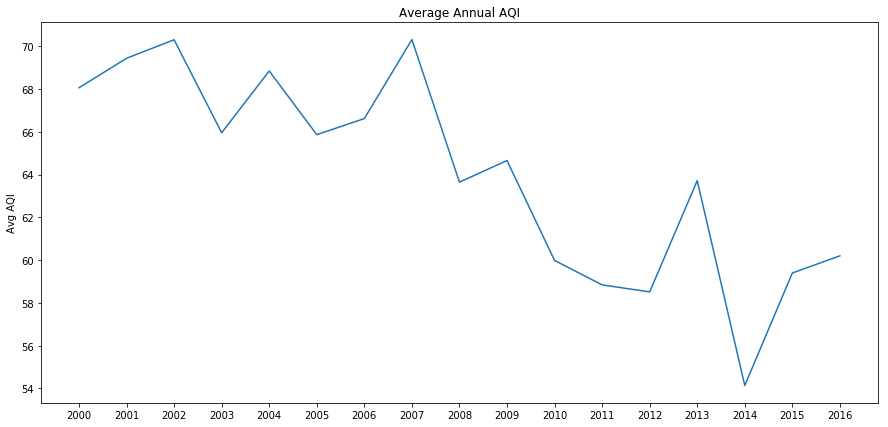

In [10]:
#Using airquality df, reset index to dates in order to select by year
airquality.index = airquality.date

#Generate date range to plot
x = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', 
     '2009', '2010', '2011', '2012', '2013', '2014', '2015',  '2016'
]

#Select for each year and calculate mean aqi
means = [airquality['2000'].aqi.mean(), airquality['2001'].aqi.mean(), airquality['2002'].aqi.mean(),
         airquality['2003'].aqi.mean(), airquality['2004'].aqi.mean(), airquality['2005'].aqi.mean(),
         airquality['2006'].aqi.mean(), airquality['2007'].aqi.mean(), airquality['2008'].aqi.mean(),
         airquality['2009'].aqi.mean(), airquality['2010'].aqi.mean(), airquality['2011'].aqi.mean(),
         airquality['2012'].aqi.mean(), airquality['2013'].aqi.mean(), airquality['2014'].aqi.mean(), 
         airquality['2015'].aqi.mean(), airquality['2016'].aqi.mean()
]

#create plot
plt.figure(figsize=(15, 7))
plt.plot(x, means)
plt.title('Average Annual AQI')
plt.ylabel('Avg AQI')
plt.show()

Overall the average AQI appears to be decreasing with time.  However, despite the apparent downward trend, average air quality remains moderate (AQI between 51 and 100) for all years. The highest average AQIs were observed in 2002 and 2007, and the lowest occurred in 2014.  Let's compare the minimum and maximum values to see if there's a real difference between the two.

First, we'll need to determine which year the actual maximum average AQI occurred since we cannot differentiate between 2002 and 2007 from the graph alone. 

In [11]:
#Determine which year has the max average
airquality['2002'].mean() > airquality['2007'].mean()

aqi    False
dtype: bool

Ok, so the maximum value occurred in 2007.  Let's compare 2007 and 2014 using a t-test.

In [23]:
#import ttest
from scipy.stats import ttest_ind
print(ttest_ind(airquality['2007'].aqi, airquality['2017'].aqi, equal_var=False))

Ttest_indResult(statistic=3.3351699721994983, pvalue=0.00089808235967214962)


Good news! The difference between 2007 and 2014 AQIs is statistically significant.  This means the average AQI in 2014 was indeed lower than the average AQI in 2007.

### Further Research

I'd like to evaluate long term trends using regression analysis techniques over a longer time period.  This would allow for a more robust analysis of long term trends rather than simply comparing averages from different years.

I also think it'd be really interesting to incorporate different variables such as weather patterns, temperature, and historical AQI measurements into to a ML model that could predict air quality similar to how we predict the weather.  This could have public health applications and allow people with to plan ahead with respect to outdoor activities or encourage people to change their behaviors (i.e. avoid car travel or take public transit) on high risk days to preemptively mitigate poor air quality.  Current forecasts only extend out 24-48 hrs.  

Another interesting application would be to use air quality data to predict respiratory related diseases.  I'm not sure how exactly how that could be done, but I think ML techniques could be utilized.